# Exploring Restaurant locations in LA for a new restaurant set up 

## Table of contents
* [Introduction: discussing the problem](#introduction)
* [Data collection/wrangling](#data)
* [Methodology : Exploring Restaurants](#methodology)
* [Analysis : Clustering with KMeans()](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: discussing the problem <a name="introduction"></a>

Restaurant business is one of the most sought-after businesses in Los Angeles (LA). LA, in particular, is an amazing place to dine out owing to its wide variety of international cuisines, the quality of food and the services offered. Given the high demand for quality, a restaurant needs to get several factors right in order to survive here. In this brief report, I tried to investigate some of these factors by exploring the restaurants based in the various neighborhoods of Los Angeles (LA). I have tried to keep the discussion general when it comes to the kinds of restaurant and their features and rather focus on the global features like density of restaurants in a region, their frequency and so on. 

The business direction that I have in mind is actually two-fold. One is directed towards individuals looking for places to eat or even people looking for places to rent based on restaurant types or frequency. The other direction is for corporations/individuals looking to open a new restaurant.  


## Data collection/wrangling <a name="data"></a>

The location data for LA was obtained from - https://usc.data.socrata.com/dataset/Los-Angeles-Neighborhood-Map/r8qd-yxsr. I used the API endpoint to retrieve the json file consisting of the neighborhood data and its location. The data consisted of 272 unique neighborhoods. To make the analysis slightly easier, I used a distance function from the LA central coordinates to reduce the number of rows to 199. This is just so that I can reduce the number of calls to the foursquare location app. The Foursquare app is used to explore the venues close to each of these 199 neighborhoods and only the restaurant venues were kept for further analysis.

I plan to use 2 ideas for segregating/clustering the neighborhoods based on their restaurant venues. One idea is to find the density of restaurants in each neighborhood. This will help anyone trying to open a new restaurant by either avoiding overcrowded areas or alternately could help finding popular venues to avoid competition. The above data also includes the area of each neighborhood in square miles which can be used to compute this density I mentioned.

The next idea to explore is the kind of restaurant. Here, one can again use clustering but now based on the frequency of occurrence of each restaurant in a Neighborhood just like the one done in the New York data set. Once we find the relevant cluster here, we can then look for its intersection with the clusters found above to fine tune the relevant neighborhood where one wants to open his/her restaurant.

The centroid coordinates of LA was found by using the geocoder library in the geopy module of python. Then to explore venues in a given neighborhood, we use Foursquare which was introduced earlier in the course. 

In [1]:
# Let's get all the libraries we need 
import numpy as np # library to handle data in a vectorized manner

import wget
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!pip install geopy # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

#!conda install -c folium --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


print('Libraries imported.')

/Users/jyotisman/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Libraries imported.


In [2]:
# Obataining data from 
# https://usc.data.socrata.com/dataset/Los-Angeles-Neighborhood-Map/r8qd-yxsr
la_data = wget.download('https://usc.data.socrata.com/resource/9utn-waje.json')
print('Data downloaded!')

Data downloaded!


In [3]:
with open(la_data) as json_data:
    la_data = json.load(json_data)

In [4]:
df = pd.DataFrame(la_data)
df.head()

,set,slug,the_geom,kind,external_i,name,display_na,sqmi,type,latitude,longitude,location
0,L.A. County Neighborhoods (Current),acton,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",L.A. County Neighborhood (Current),acton,Acton,Acton L.A. County Neighborhood (Current),39.3391089485,unincorporated-area,-118.16981019229348,34.497355239240846,POINT(34.497355239240846 -118.16981019229348)
1,L.A. County Neighborhoods (Current),adams-normandie,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",L.A. County Neighborhood (Current),adams-normandie,Adams-Normandie,Adams-Normandie L.A. County Neighborhood (Curr...,0.805350187789,segment-of-a-city,-118.30020800000011,34.031461499124156,POINT(34.031461499124156 -118.30020800000011)
2,L.A. County Neighborhoods (Current),agoura-hills,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",L.A. County Neighborhood (Current),agoura-hills,Agoura Hills,Agoura Hills L.A. County Neighborhood (Current),8.14676029818,standalone-city,-118.75988450000015,34.146736499122795,POINT(34.146736499122795 -118.75988450000015)
3,L.A. County Neighborhoods (Current),agua-dulce,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",L.A. County Neighborhood (Current),agua-dulce,Agua Dulce,Agua Dulce L.A. County Neighborhood (Current),31.4626319451,unincorporated-area,-118.3171036690717,34.504926999796837,POINT(34.504926999796837 -118.3171036690717)
4,L.A. County Neighborhoods (Current),alhambra,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...",L.A. County Neighborhood (Current),alhambra,Alhambra,Alhambra L.A. County Neighborhood (Current),7.62381430605,standalone-city,-118.13651200000021,34.085538999123571,POINT(34.085538999123571 -118.13651200000021)


In [5]:
# dropping irrelevant and redundant colums
df.drop(columns=['display_na', 'external_i', 'kind', 'location','set','slug','the_geom','type'],axis=1,inplace=True)
df.head()

,name,sqmi,latitude,longitude
0,Acton,39.3391089485,-118.16981019229348,34.497355239240846
1,Adams-Normandie,0.805350187789,-118.30020800000011,34.031461499124156
2,Agoura Hills,8.14676029818,-118.75988450000015,34.146736499122795
3,Agua Dulce,31.4626319451,-118.3171036690717,34.504926999796837
4,Alhambra,7.62381430605,-118.13651200000021,34.085538999123571


In [6]:
df.shape

(272, 4)

In [7]:
len(df.name.unique())

272

In [8]:
#the latitude and longitude columns are flipped here, so need to fix this
df.rename(columns={'latitude':'Longitude', 'longitude':'Latitude', 'name' : 'Neighbourhood'}, inplace=True)
df.head()

,Neighbourhood,sqmi,Longitude,Latitude
0,Acton,39.3391089485,-118.16981019229348,34.497355239240846
1,Adams-Normandie,0.805350187789,-118.30020800000011,34.031461499124156
2,Agoura Hills,8.14676029818,-118.75988450000015,34.146736499122795
3,Agua Dulce,31.4626319451,-118.3171036690717,34.504926999796837
4,Alhambra,7.62381430605,-118.13651200000021,34.085538999123571


In [9]:
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)
df['sqmi'] = df['sqmi'].astype(float)
df.dtypes

Neighbourhood     object
sqmi             float64
Longitude        float64
Latitude         float64
dtype: object

In [10]:
address = 'Los Angeles, California'

geolocator = Nominatim(user_agent="LA_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Los Angeles are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Los Angeles are 34.0536909, -118.2427666.


In [11]:
# create map of LA using latitude and longitude values
map_LA = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA)  
    
map_LA

In [12]:
# approximate radius of earth in km
R = 6373.0
#Defining a distance function to find the distance of the neighborhoods from LA centroid
def distfromLA(lat,lon):
    lat1 = np.radians(latitude)
    lon1 = np.radians(longitude)
    lat2 = np.radians(lat)
    lon2 = np.radians(lon)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan(np.sqrt(a)/ np.sqrt(1 - a))

    distance = R * c
    return distance

In [13]:
# Keeping neighborhoods only within a given radius (given by rad) around the LA centroid  
rad = 30
dis = distfromLA(df['Latitude'],df['Longitude'])
df_trunc = df[dis<=rad]

In [14]:
df_trunc.shape

(199, 4)

In [15]:
# create map of LA using latitude and longitude values
map_LA = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(df_trunc['Latitude'], df_trunc['Longitude'], df_trunc['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA)  
    
map_LA

### Foursquare  

Now to obtain the nearby venues corresponding to each neighborhood, we invoke the Foursquare app. 

In [16]:
CLIENT_ID = 'VSNQS55IP3RD5F5K4NA5TOICT4ENYU1XTUDBVHU2ROH4HOE1' # your Foursquare ID
CLIENT_SECRET = 'G4VAQYSKTGJR10VQXEV2NDDWLVLDYYBAXJ53BN3FSIQGYMQN' # your Foursquare Secret
VERSION = '20200624' # Foursquare API version
LIMIT = 70

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VSNQS55IP3RD5F5K4NA5TOICT4ENYU1XTUDBVHU2ROH4HOE1
CLIENT_SECRET:G4VAQYSKTGJR10VQXEV2NDDWLVLDYYBAXJ53BN3FSIQGYMQN


In [17]:
#defining a function to explore the nearby venues of each neighborhood

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
LA_venues = getNearbyVenues(names=df_trunc['Neighbourhood'],
                                   latitudes=df_trunc['Latitude'],
                                   longitudes=df_trunc['Longitude']
                                  )

Adams-Normandie
Alhambra
Alondra Park
Artesia
Altadena
Arcadia
Arleta
Arlington Heights
Athens
Atwater Village
Avocado Heights
Vermont-Slauson
Baldwin Hills/Crenshaw
Baldwin Park
Bel-Air
Bellflower
Bell Gardens


KeyError: 'groups'

In [ ]:
print(LA_venues.shape)
LA_venues.head()

In [ ]:
#Saved Foursquare data locally in case number of calls for a day are exhausted
path=r'/Users/jyotisman/Desktop/'
LA_venues.to_csv(path+'LA_venues.csv', index=False)

In [20]:
path=r'/Users/jyotisman/Desktop/'
LA_venues = pd.read_csv(path+'LA_venues.csv')
LA_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adams-Normandie,34.031461,-118.300208,Orange Door Sushi,34.032485,-118.299368,Sushi Restaurant
1,Adams-Normandie,34.031461,-118.300208,Shell,34.033095,-118.300025,Gas Station
2,Adams-Normandie,34.031461,-118.300208,Little Xian,34.032292,-118.299465,Sushi Restaurant
3,Adams-Normandie,34.031461,-118.300208,Sushi Delight,34.032501,-118.299454,Sushi Restaurant
4,Adams-Normandie,34.031461,-118.300208,Tacos La Estrella,34.032230,-118.300757,Taco Place


In [21]:
venue_cat = LA_venues['Venue Category'].unique().tolist()

In [22]:
# Getting all the restaurant venues only
venue_rest = []
for item in venue_cat:
    if item.split()[-1] == 'Restaurant':
        venue_rest.append(item)
venue_rest

['Sushi Restaurant',
 'Mexican Restaurant',
 'Fast Food Restaurant',
 'Indian Restaurant',
 'Taiwanese Restaurant',
 'Asian Restaurant',
 'Thai Restaurant',
 'Vegetarian / Vegan Restaurant',
 'Chinese Restaurant',
 'Vietnamese Restaurant',
 'Japanese Restaurant',
 'Italian Restaurant',
 'Shabu-Shabu Restaurant',
 'Latin American Restaurant',
 'Korean Restaurant',
 'Seafood Restaurant',
 'Mediterranean Restaurant',
 'Dumpling Restaurant',
 'Satay Restaurant',
 'Southern / Soul Food Restaurant',
 'Doner Restaurant',
 'American Restaurant',
 'Cuban Restaurant',
 'New American Restaurant',
 'Brazilian Restaurant',
 'Restaurant',
 'Ethiopian Restaurant',
 'French Restaurant',
 'Cajun / Creole Restaurant',
 'Filipino Restaurant',
 'Dim Sum Restaurant',
 'Greek Restaurant',
 'Middle Eastern Restaurant',
 'Falafel Restaurant',
 'South American Restaurant',
 'Ramen Restaurant',
 'Spanish Restaurant',
 'Peruvian Restaurant',
 'Persian Restaurant',
 'Australian Restaurant',
 'Hawaiian Restaurant'

In [23]:
LA_ven_rest = LA_venues[LA_venues['Venue Category'].isin(venue_rest)]

In [24]:
LA_ven_rest.shape

(671, 7)

In [25]:
LA_ven_rest.reset_index(inplace=True)

In [26]:
# Dataframe consisting of all the restaurants for each neighborhood
LA_ven_rest.head()

,index,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Adams-Normandie,34.031461,-118.300208,Orange Door Sushi,34.032485,-118.299368,Sushi Restaurant
1,2,Adams-Normandie,34.031461,-118.300208,Little Xian,34.032292,-118.299465,Sushi Restaurant
2,3,Adams-Normandie,34.031461,-118.300208,Sushi Delight,34.032501,-118.299454,Sushi Restaurant
3,9,Alhambra,34.085539,-118.136512,Manny's Tacos,34.087148,-118.135275,Mexican Restaurant
4,12,Alhambra,34.085539,-118.136512,Wendy’s,34.087705,-118.135010,Fast Food Restaurant


In [27]:
LA_ven_rest.drop(columns = ['index'],axis=1,inplace=True)
LA_ven_rest.head()

/Users/jyotisman/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adams-Normandie,34.031461,-118.300208,Orange Door Sushi,34.032485,-118.299368,Sushi Restaurant
1,Adams-Normandie,34.031461,-118.300208,Little Xian,34.032292,-118.299465,Sushi Restaurant
2,Adams-Normandie,34.031461,-118.300208,Sushi Delight,34.032501,-118.299454,Sushi Restaurant
3,Alhambra,34.085539,-118.136512,Manny's Tacos,34.087148,-118.135275,Mexican Restaurant
4,Alhambra,34.085539,-118.136512,Wendy’s,34.087705,-118.135010,Fast Food Restaurant


## Methodology : Exploring Restaurants <a name="methodology"></a>

As mentioned earlier, we will be analysing restaurant location to predict areas for new restaurant set ups. First part is basically exploring the restaurants and computing the densities for each neighborhood. Then we can form clusters with high, low and medium densities. This is a very good starting point for stakeholders as gives them an idea of which regions are already saturated with restaurants and which are not. 

Then we agin use the clustering technique to now cluster neighborhoods based on their frequency in the neighborhood. This is similar to what was done in the New York dataset. Then one can use both these kinds of clusters to now find densities of particular kind of restaurants in a region. 

A further exploration could also be looking at the distance of a particular restaurant from neighborhood centre and cluster regions based on that. We don't explore this here. But one can easily do a follow up in this direction using my analysis.

In [28]:
# one hot encoding for the restaurants
LA_onehot = pd.get_dummies(LA_ven_rest[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
LA_onehot['Neighbourhood'] = LA_ven_rest['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [LA_onehot.columns[-1]] + list(LA_onehot.columns[:-1])
LA_onehot = LA_onehot[fixed_columns]

LA_onehot.head()

,Neighbourhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Cuban Restaurant,Dim Sum Restaurant,Donburi Restaurant,Doner Restaurant,Dongbei Restaurant,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Greek Restaurant,Hawaiian Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Satay Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Adams-Normandie,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,Adams-Normandie,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,Adams-Normandie,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,Alhambra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Alhambra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
#getting the restaurants of each category for every neighborhood
LA_grouped = LA_onehot.groupby('Neighbourhood').sum().reset_index()
LA_grouped

,Neighbourhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Cuban Restaurant,Dim Sum Restaurant,Donburi Restaurant,Doner Restaurant,Dongbei Restaurant,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Greek Restaurant,Hawaiian Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Satay Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Adams-Normandie,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0
1,Alhambra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Arcadia,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,Arlington Heights,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,2,0
4,Artesia,0,0,1,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,2
5,Atwater Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Avocado Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Baldwin Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Bell Gardens,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,Bellflower,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
#adding a column showing total restaurants for each neighborhood
LA_grouped['Total_rest'] = LA_grouped.sum(axis = 1)
LA_grouped.head()

,Neighbourhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Cuban Restaurant,Dim Sum Restaurant,Donburi Restaurant,Doner Restaurant,Dongbei Restaurant,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Greek Restaurant,Hawaiian Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Satay Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total_rest
0,Adams-Normandie,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,3
1,Alhambra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2,Arcadia,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,7
3,Arlington Heights,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,2,0,11
4,Artesia,0,0,1,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,2,18


In [31]:
#Adding the area column to be able to compute densities 
LA_grouped['area'] = [df_trunc[df_trunc['Neighbourhood']==neigh]['sqmi'].values[0] for neigh in LA_grouped['Neighbourhood']]

In [32]:
LA_grouped.head()

,Neighbourhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Cuban Restaurant,Dim Sum Restaurant,Donburi Restaurant,Doner Restaurant,Dongbei Restaurant,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Greek Restaurant,Hawaiian Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Satay Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total_rest,area
0,Adams-Normandie,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,3,0.805350
1,Alhambra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,7.623814
2,Arcadia,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,7,11.150797
3,Arlington Heights,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,2,0,11,1.031415
4,Artesia,0,0,1,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,2,18,1.632204


In [33]:
# now computing the restaurant densities for each neighborhood
LA_grouped['density'] = LA_grouped['Total_rest']/LA_grouped['area']
LA_grouped.head()

,Neighbourhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Cuban Restaurant,Dim Sum Restaurant,Donburi Restaurant,Doner Restaurant,Dongbei Restaurant,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Greek Restaurant,Hawaiian Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Satay Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total_rest,area,density
0,Adams-Normandie,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,3,0.805350,3.725088
1,Alhambra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,7.623814,0.262336
2,Arcadia,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,7,11.150797,0.627758
3,Arlington Heights,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,2,0,11,1.031415,10.664958
4,Artesia,0,0,1,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,2,18,1.632204,11.028032


In [34]:
LA_density = LA_grouped[['Neighbourhood','Total_rest','area','density']]
LA_density.head()

,Neighbourhood,Total_rest,area,density
0,Adams-Normandie,3,0.805350,3.725088
1,Alhambra,2,7.623814,0.262336
2,Arcadia,7,11.150797,0.627758
3,Arlington Heights,11,1.031415,10.664958
4,Artesia,18,1.632204,11.028032


## Analysis : Clustering with KMeans() <a name="analysis"></a>

Now we are ready to run our K-means algorithm using Total_rest and density as the features. Sqrmile is a redundant feature here, so we won't be using that.

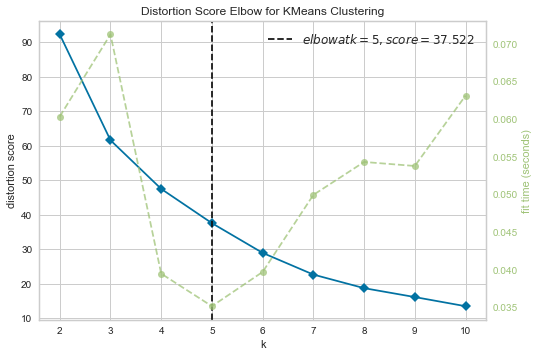

In [35]:
#First scaling the features and then using the elbow method to find the optimum k for KMeans()
X = LA_density.drop('Neighbourhood',1)[['Total_rest','density']].values
X = StandardScaler().fit_transform(X)
model = KElbowVisualizer(KMeans(), k=10)
model.fit(X)
model.show()

In [36]:
model.k_scores_

[92.22750054225347,
 61.56282123268842,
 47.456402802597275,
 37.521897889431344,
 28.90320215225107,
 22.61865235980505,
 18.68495775946502,
 16.102019821644966,
 13.452884927128247]

In [37]:
kclusters = 5
k_means = KMeans(init="k-means++", n_clusters=kclusters,random_state=0)

In [38]:
k_means.fit(X)

KMeans(n_clusters=5, random_state=0)

In [39]:
k_means.labels_

array([0, 2, 4, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 1, 2, 2,
       4, 2, 2, 4, 4, 2, 2, 2, 4, 2, 4, 2, 4, 4, 0, 2, 2, 3, 2, 2, 2, 2,
       2, 0, 0, 2, 1, 4, 2, 4, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 4, 0, 4,
       4, 3, 2, 2, 0, 4, 4, 2, 2, 2, 2, 2, 2, 2, 3, 0, 0, 2, 2, 2, 2, 2,
       0, 2, 2, 4, 2, 2, 2, 4, 0, 2, 2, 4, 0, 0, 4, 2, 2, 4, 2, 0, 2, 2,
       3, 3, 2, 2, 2, 2, 2, 2], dtype=int32)

In [40]:
LA_density['Cluster Label'] = k_means.labels_
LA_density.head()

/Users/jyotisman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Neighbourhood,Total_rest,area,density,Cluster Label
0,Adams-Normandie,3,0.805350,3.725088,0
1,Alhambra,2,7.623814,0.262336,2
2,Arcadia,7,11.150797,0.627758,4
3,Arlington Heights,11,1.031415,10.664958,3
4,Artesia,18,1.632204,11.028032,3


In [43]:
LA_cluster_merged = LA_density.join(LA_ven_rest.set_index('Neighbourhood'),
                                    on ='Neighbourhood', 
                                    how='outer').drop_duplicates('Neighbourhood',
                                                                 keep='first').drop(columns=['Venue','Venue Latitude',
                                                                                            'Venue Longitude',
                                                                                            'Venue Category'])
LA_cluster_merged.rename(columns={'Neighbourhood Latitude':'Latitude','Neighbourhood Longitude':'Longitude'},inplace=True)
LA_cluster_merged.head()

,Neighbourhood,Total_rest,area,density,Cluster Label,Latitude,Longitude
0,Adams-Normandie,3,0.805350,3.725088,0,34.031461,-118.300208
1,Alhambra,2,7.623814,0.262336,2,34.085539,-118.136512
2,Arcadia,7,11.150797,0.627758,4,34.133230,-118.030419
3,Arlington Heights,11,1.031415,10.664958,3,34.044910,-118.323408
4,Artesia,18,1.632204,11.028032,3,33.866896,-118.080101


In [44]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(x)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(LA_cluster_merged['Latitude'], LA_cluster_merged['Longitude'], LA_cluster_merged['Neighbourhood'], LA_cluster_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [45]:
k_means.cluster_centers_

array([[-0.08462361,  0.70592797],
       [ 3.52128248,  3.49253055],
       [-0.55974133, -0.52107599],
       [ 1.68717782,  1.94011763],
       [ 0.67453697, -0.13826821]])

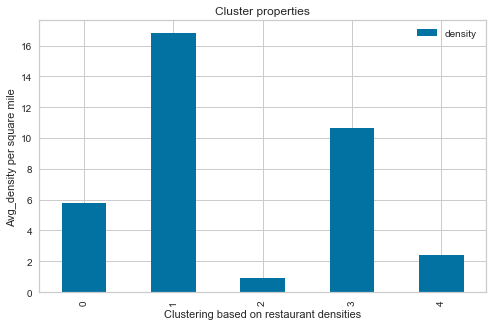

In [46]:
LA_cluster_merged[['Cluster Label','density']].groupby('Cluster Label').mean().plot(kind='bar',figsize=(8, 5))
                                                 
plt.title('Cluster properties')
plt.ylabel('Avg_density per square mile') 
plt.xlabel('Clustering based on restaurant densities')

plt.show()

We would characterize cluster 2 as low density, 0 and 4 as medium while 1 and 3 as high.

The next idea to explore is the kind of restaurant. Here, one can again use clustering but now based on the frequency of occurence of each restaurant in a Neighborhood just like the one done in the New York data set. Once we find the relevant cluster here, we can then look for its intersection with the clusters found above to fine tune the relevant neighborhood where one can open his/her restaurant.

In [47]:
LA_freq_grouped = LA_onehot.groupby('Neighbourhood').mean().reset_index()
LA_freq_grouped

,Neighbourhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Cuban Restaurant,Dim Sum Restaurant,Donburi Restaurant,Doner Restaurant,Dongbei Restaurant,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Greek Restaurant,Hawaiian Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Satay Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Adams-Normandie,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
1,Alhambra,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.500000,0.00,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
2,Arcadia,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.142857,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.142857,0.00,0.000000,0.000000,0.00,0.000000,0.0,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.00,0.000000,0.000000
3,Arlington Heights,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.090909,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.181818,0.000000,0.181818,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.00,0.181818,0.000000
4,Artesia,0.000000,0.000000,0.055556,0.00,0.000000,0.000000,0.0,0.0,0.222222,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.055556,0.00,0.000000,0.000000,0.00,0.388889,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.055556,0.00,0.055556,0.111111
5,Atwater Village,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.333333,0.00,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
6,Avocado Heights,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.400000,0.00,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000

In [48]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [49]:
#Finding top 5 restaurants in each neighborhood
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = LA_freq_grouped['Neighbourhood']

for ind in np.arange(LA_freq_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(LA_freq_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adams-Normandie,Sushi Restaurant,Vietnamese Restaurant,Doner Restaurant,Hawaiian Restaurant,Greek Restaurant
1,Alhambra,Fast Food Restaurant,Mexican Restaurant,Vietnamese Restaurant,Dongbei Restaurant,Hawaiian Restaurant
2,Arcadia,Italian Restaurant,Thai Restaurant,Japanese Restaurant,Fast Food Restaurant,Mexican Restaurant
3,Arlington Heights,Vegetarian / Vegan Restaurant,Korean Restaurant,Latin American Restaurant,Mexican Restaurant,Sushi Restaurant
4,Artesia,Indian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant
5,Atwater Village,Fast Food Restaurant,Mediterranean Restaurant,Mexican Restaurant,Vietnamese Restaurant,Dongbei Restaurant
6,Avocado Heights,Mexican Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Dongbei Restaurant,Hawaiian Restaurant
7,Baldwin Park,Italian Restaurant,Latin American Restaurant,Mexican Restaurant,Dongbei Restaurant,Greek Restaurant
8,Bell Gardens,Fast Food Restaurant,Latin American Restaurant,Mexican Restaurant,Seafood Restaurant,Vietnamese Restaurant
9,Bellflower,Fast Food Restaurant,Mexican Restaurant,Chinese Restaurant,Vietnamese Restaurant,Dongbei Restaurant


In [50]:
#Getting the features array for the clustering task
X2 = LA_freq_grouped.drop('Neighbourhood',1).values

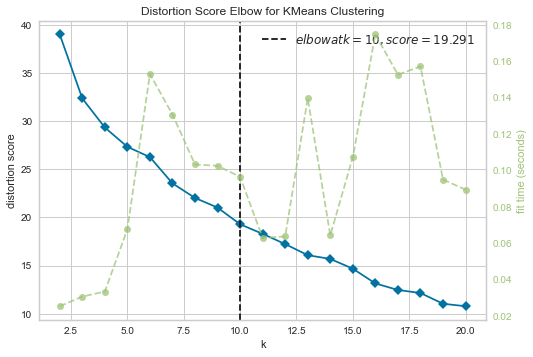

In [51]:
model = KElbowVisualizer(KMeans(), k=20)
model.fit(X2)
model.show()

In [52]:
model.elbow_value_

10

In [53]:
kclusters = 10
k_means2 = KMeans(n_clusters=kclusters, random_state=0).fit(X2) 
k_means2.labels_

array([4, 0, 1, 4, 1, 0, 0, 2, 0, 0, 4, 3, 6, 0, 4, 6, 1, 4, 0, 1, 3, 3,
       4, 6, 3, 0, 1, 4, 6, 4, 0, 4, 4, 7, 4, 1, 2, 0, 6, 4, 3, 9, 3, 0,
       1, 3, 0, 0, 4, 0, 0, 4, 2, 8, 8, 6, 4, 5, 1, 1, 0, 3, 4, 4, 6, 0,
       1, 4, 4, 2, 0, 4, 0, 3, 1, 0, 7, 1, 6, 3, 4, 0, 4, 7, 4, 1, 4, 1,
       7, 5, 4, 1, 1, 4, 6, 4, 0, 4, 9, 4, 4, 4, 0, 1, 4, 4, 7, 0, 3, 0,
       4, 4, 0, 4, 3, 3, 3, 3], dtype=int32)

In [54]:
#frequency of each restaurant type for every neighborhood
LA_merged = LA_freq_grouped.join(LA_cluster_merged.set_index('Neighbourhood'),
                                    on ='Neighbourhood')
                                    
LA_merged

,Neighbourhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Cuban Restaurant,Dim Sum Restaurant,Donburi Restaurant,Doner Restaurant,Dongbei Restaurant,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Greek Restaurant,Hawaiian Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Satay Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total_rest,area,density,Cluster Label,Latitude,Longitude
0,Adams-Normandie,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,3,0.805350,3.725088,0,34.031461,-118.300208
1,Alhambra,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.500000,0.00,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,2,7.623814,0.262336,2,34.085539,-118.136512
2,Arcadia,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.142857,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.142857,0.00,0.000000,0.000000,0.00,0.000000,0.0,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.00,0.000000,0.000000,7,11.150797,0.627758,4,34.133230,-118.030419
3,Arlington Heights,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.090909,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.181818,0.000000,0.181818,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.00,0.181818,0.000000,11,1.031415,10.664958,3,34.044910,-118.323408
4,Artesia,0.000000,0.000000,0.055556,0.00,0.000000,0.000000,0.0,0.0,0.222222,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.055556,0.00,0.000000,0.000000,0.00,0.388889,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.055556,0.00,0.055556,0.111111,18,1.632204,11.028032,3,33.866896,-118.080101
5,Atwater Village,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.333333,0.00,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [55]:
#adding the cluster label values column
neighborhood_venues2 = neighborhoods_venues_sorted
neighborhood_venues2.insert(0, 'Cluster Labels 2', k_means2.labels_)
neighborhood_venues2

,Cluster Labels 2,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,4,Adams-Normandie,Sushi Restaurant,Vietnamese Restaurant,Doner Restaurant,Hawaiian Restaurant,Greek Restaurant
1,0,Alhambra,Fast Food Restaurant,Mexican Restaurant,Vietnamese Restaurant,Dongbei Restaurant,Hawaiian Restaurant
2,1,Arcadia,Italian Restaurant,Thai Restaurant,Japanese Restaurant,Fast Food Restaurant,Mexican Restaurant
3,4,Arlington Heights,Vegetarian / Vegan Restaurant,Korean Restaurant,Latin American Restaurant,Mexican Restaurant,Sushi Restaurant
4,1,Artesia,Indian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant
5,0,Atwater Village,Fast Food Restaurant,Mediterranean Restaurant,Mexican Restaurant,Vietnamese Restaurant,Dongbei Restaurant
6,0,Avocado Heights,Mexican Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Dongbei Restaurant,Hawaiian Restaurant
7,2,Baldwin Park,Italian Restaurant,Latin American Restaurant,Mexican Restaurant,Dongbei Restaurant,Greek Restaurant
8,0,Bell Gardens,Fast Food Restaurant,Latin American Restaurant,Mexican Restaurant,Seafood Restaurant,Vietnamese Restaurant
9,0,Bellflower,Fast Food Restaurant,Mexican Restaurant,Chinese Restaurant,Vietnamese Restaurant,Dongbei Restaurant


In [56]:
#Final dataframe consisting of both the cluster labels for use in the final analysis 
LA_final_merged = LA_merged.join(neighborhood_venues2.set_index('Neighbourhood'),
                                    on ='Neighbourhood')
                                    
LA_final_merged.head()

,Neighbourhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Cuban Restaurant,Dim Sum Restaurant,Donburi Restaurant,Doner Restaurant,Dongbei Restaurant,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Greek Restaurant,Hawaiian Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Satay Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total_rest,area,density,Cluster Label,Latitude,Longitude,Cluster Labels 2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adams-Normandie,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,3,0.805350,3.725088,0,34.031461,-118.300208,4,Sushi Restaurant,Vietnamese Restaurant,Doner Restaurant,Hawaiian Restaurant,Greek Restaurant
1,Alhambra,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,2,7.623814,0.262336,2,34.085539,-118.136512,0,Fast Food Restaurant,Mexican Restaurant,Vietnamese Restaurant,Dongbei Restaurant,Hawaiian Restaurant
2,Arcadia,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.000000,0.0,0.142857,0.142857,0.000000,0.0,0.000000,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.142857,0.0,0.0,0.0,0.000000,0.0,0.000000,0.142857,0.0,0.000000,0.000000,7,11.150797,0.627758,4,34.133230,-118.030419,1,Italian Restaurant,Thai Restaurant,Japanese Restaurant,Fast Food Restaurant,Mexican Restaurant
3,Arlington Heights,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.181818,0.0,0.181818,0.0,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.000000,0.0,0.0,0.0,0.090909,0.0,0.000000,0.000000,0.0,0.181818,0.000000,11,1.031415,10.664958,3,34.044910,-118.323408,4,Vegetarian / Vegan Restaurant,Korean Restaurant,Latin American Restaurant,Mexican Restaurant,Sushi Restaurant
4,Artesia,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.388889,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.055556,0.055556,0.0,0.055556,0.111111,18,1.632204,11.028032,3,33.866896,-118.080101,1,Indian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant


In [102]:
# create map for showing all the 10 clusters 
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(x)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(LA_final_merged['Latitude'], LA_final_merged['Longitude'], LA_final_merged['Neighbourhood'], LA_final_merged['Cluster Labels 2']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7
        ).add_to(map_clusters2)
       
map_clusters2

## Results and Discussion <a name="results"></a>

Lets convert the density cluster labels into low, medium and high first.

In [58]:
LA_final_merged.replace({'Cluster Label': {0: 'medium', 4: 'medium', 2:'low', 3:'high', 1:'high'}}, inplace=True)

In [59]:
# columns to view
collist = ['Neighbourhood','Cluster Label'] + LA_final_merged.columns[-6:].tolist()
collist

['Neighbourhood',
 'Cluster Label',
 'Cluster Labels 2',
 '1st Most Common Venue',
 '2nd Most Common Venue',
 '3rd Most Common Venue',
 '4th Most Common Venue',
 '5th Most Common Venue']

In [60]:
# Finding each cluster and storing in a list to plot later
clusterlist = []
for cluster in range(10):
    clusterlist.append(LA_final_merged[LA_final_merged['Cluster Labels 2']==cluster][collist])

In [61]:
'''
def plotcluster(cluster):
    
    fig = plt.figure(figsize=(10,6))
    fig.subplots_adjust(hspace = 0.5)
    
    fig.add_subplot(121)
    clusterlist[cluster][collist[3]].value_counts().plot(kind='bar')
    plt.ylabel('no. of restaurants')
    
    fig.suptitle('Cluster : {}'.format(cluster), fontsize=17, y=1.05)

    fig.add_subplot(122)
    clusterlist[cluster][collist[1]].value_counts().plot(kind='bar')
    plt.ylabel('density count')

    plt.tight_layout()
    plt.show()
'''

"\ndef plotcluster(cluster):\n    \n    fig = plt.figure(figsize=(10,6))\n    fig.subplots_adjust(hspace = 0.5)\n    \n    fig.add_subplot(121)\n    clusterlist[cluster][collist[3]].value_counts().plot(kind='bar')\n    plt.ylabel('no. of restaurants')\n    \n    fig.suptitle('Cluster : {}'.format(cluster), fontsize=17, y=1.05)\n\n    fig.add_subplot(122)\n    clusterlist[cluster][collist[1]].value_counts().plot(kind='bar')\n    plt.ylabel('density count')\n\n    plt.tight_layout()\n    plt.show()\n"

Now for each cluster, among their most popular restaurants, we plot their respective counts and their segregation into the repsective density clusters.

In [89]:
def plotcluster2(cluster,pop_ven):
    
    cl = clusterlist[cluster]
    
    df2 = cl.groupby([collist[pop_ven], collist[1]])[collist[pop_ven]].count().unstack(collist[1]).fillna(0)
    ax = df2.plot(kind='bar', stacked=True)
    ax.tick_params(axis="x", labelsize=13)
    ax.tick_params(axis="y", labelsize=15)
    plt.ylabel('no. of restaurants',fontsize = 15)
    
    plt.title('Cluster : {}({} neighborhoods)'.format(cluster,cl.shape[0]), fontsize = 17, y=1.05)
    #plt.tight_layout()
    plt.show()

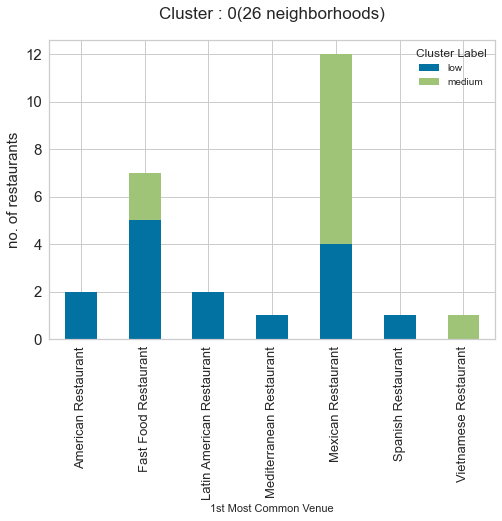

In [90]:
plotcluster2(0,3)

So, for cluster 0, in the most popular category, we have 2 American restaurants both in the low density cluster. There are 7 Fast food restaurants with 5 in low density and 2 in medium. Similarly there are 12 Mexican venues with 4 and 8 respectively in the low and medium category.

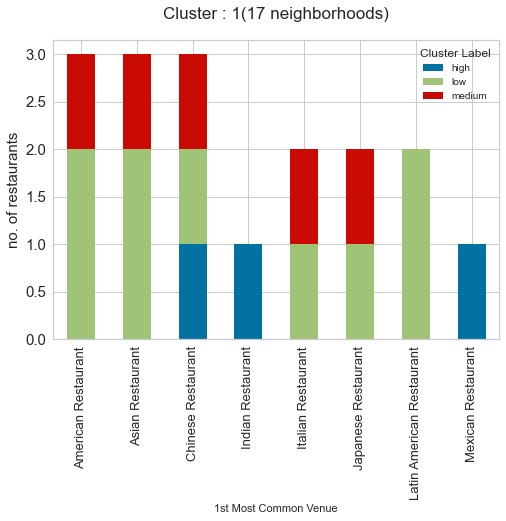

In [91]:
plotcluster2(1,3)

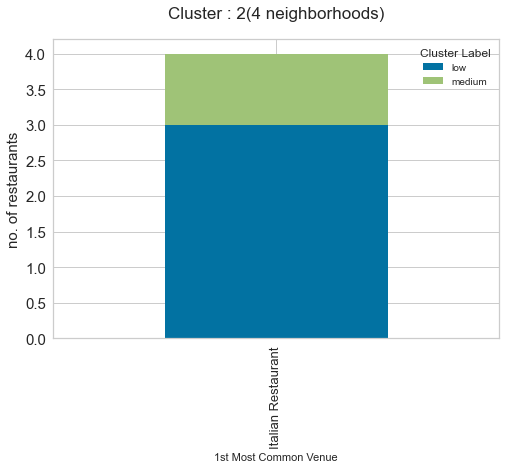

In [92]:
plotcluster2(2,3)

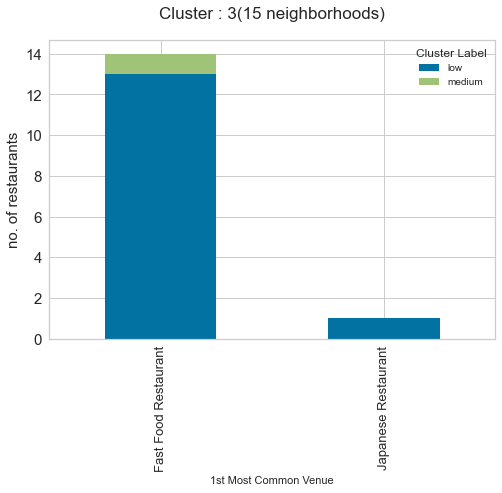

In [93]:
plotcluster2(3,3)

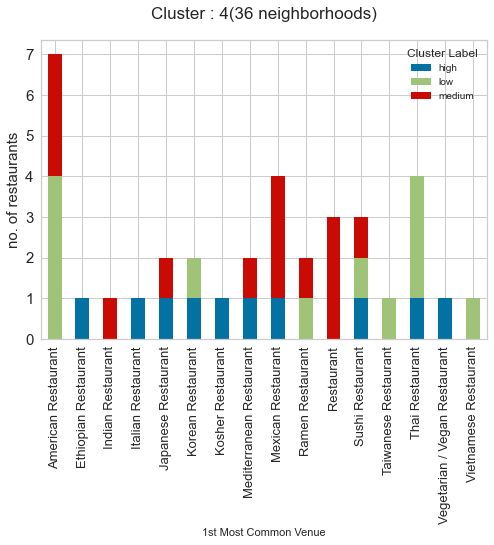

In [94]:
plotcluster2(4,3)

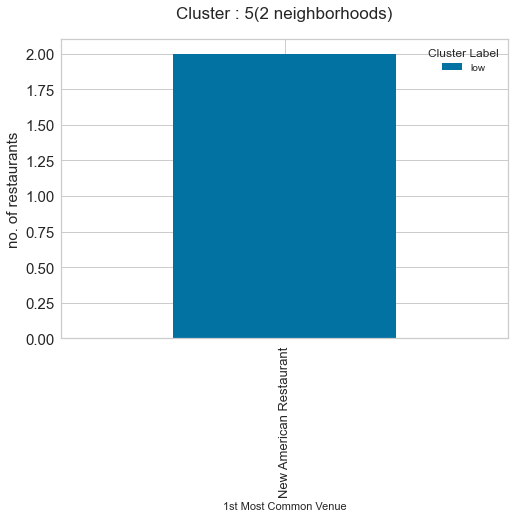

In [95]:
plotcluster2(5,3)

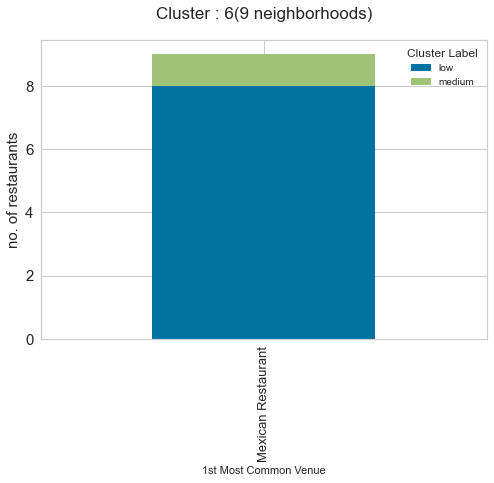

In [96]:
plotcluster2(6,3)

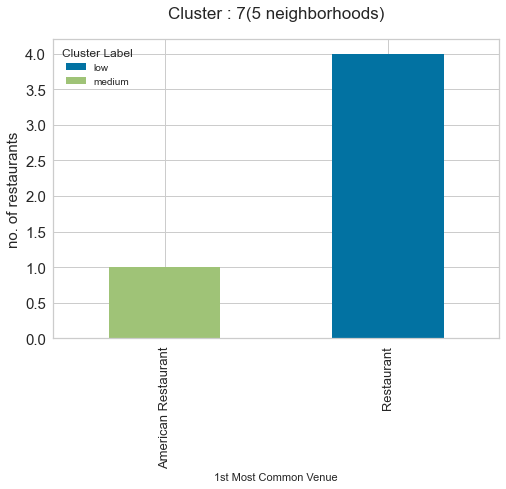

In [97]:
plotcluster2(7,3)

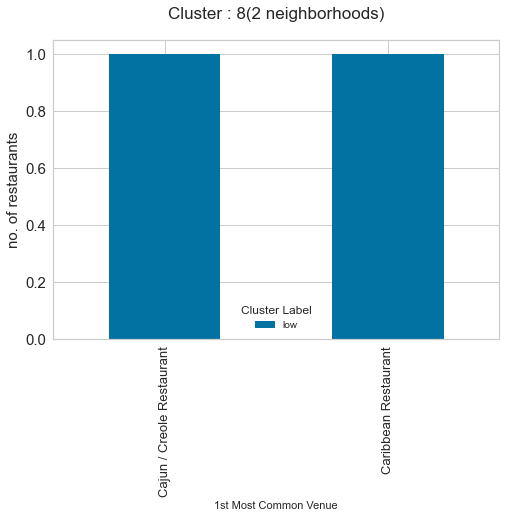

In [98]:
plotcluster2(8,3)

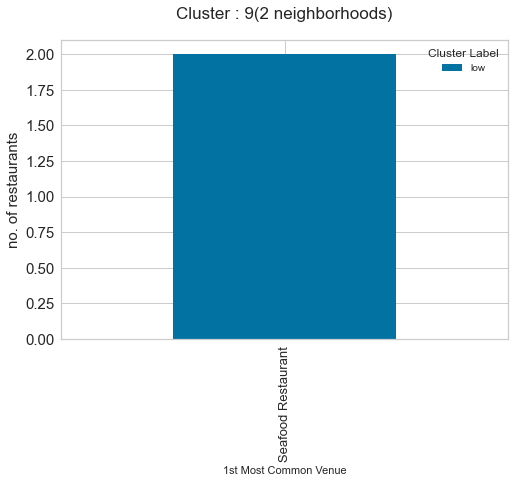

In [99]:
plotcluster2(9,3)

From the above clustering data, we can see some obvious conclusions. Cluster 2 is dominantly Italian while 3 is fast food. Similarly, anyone's interested in seafood would likely visit a neighborhood in cluster 9 or cluster 6 for Mexican. 

Now for stakeholders,let's say someone's planning to open an Italian restaurant. Firstly, one could certainly avoid Cluster 2. One could argue that these are actually in low density regions but the other thing is popularity. A low density region could also be synonymous with it being less popular. Cluster 1 could be a good option, has a very diverse option of cuisines (could correspond to a diverse audience in the vicinity) and the Italian restaurants are actually located in medium and low density regions which is a good trade off between competition and popularity. There are of course many other factors to look for but this provides a good starting point.

## Conclusion <a name="conclusion"></a>

Similar conclusions can be derived for some other restaurants as well. One can also look at the second popular venues as well to gain more information as well. Further exploration could be based on distance from public transport, availability of parking lots, population,etc. So, one can carry forward the analysis further based in the information collected in this report and make even stronger predictions.